In [1]:
# Import libraries
from pathlib import Path
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from rdkit.Chem import MolFromSmiles, rdmolops, Draw
import torch
from rdkit import Chem
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool, GATConv
from sklearn.metrics import root_mean_squared_error
sns.set_style()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: 'NoneType' object has no attribute 'origin'
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


In [2]:
# Read data
dataset = pd.read_csv(Path("../data/dataset_processed.csv"))

The dataset contains mixture of molecules, which are a problem since they will result in disconnected graphs.

Mixtures: 798


[17:48:30] WARNING: not removing hydrogen atom without neighbors
[17:48:30] WARNING: not removing hydrogen atom without neighbors
[17:48:30] WARNING: not removing hydrogen atom without neighbors


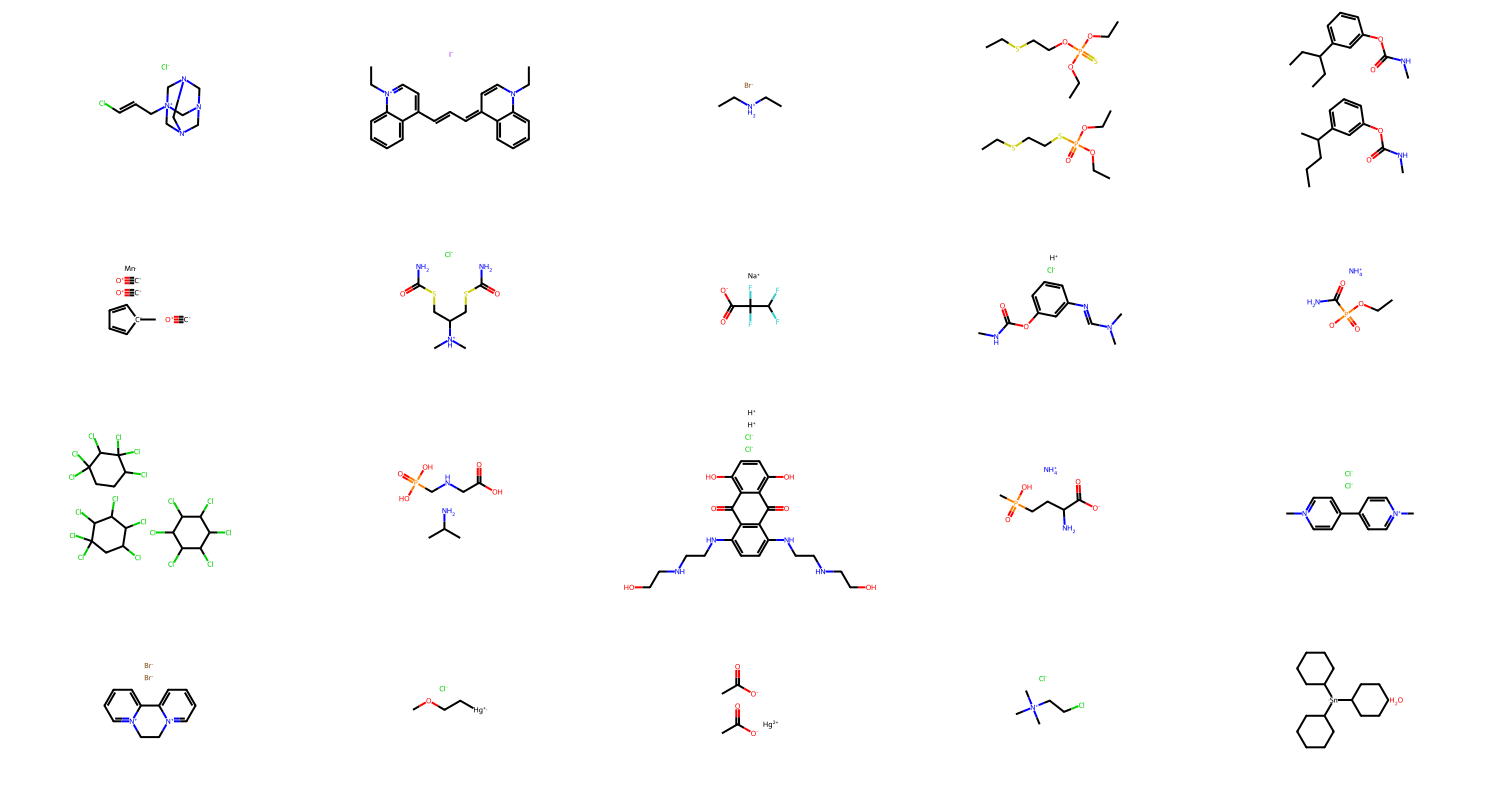

In [3]:
mixtures = dataset.loc[dataset["SMILES"].str.contains(r"\."), ]
print(f"Mixtures: {len(mixtures)}")
# Convert SMILES strings to molecule objects
molecules = []
legends = []
for index, row in mixtures.tail(20).iterrows():
    mol = MolFromSmiles(row['SMILES'])
    molecules.append(mol)

Draw.MolsToGridImage(molecules, molsPerRow=5, legends=legends, subImgSize=(300,200))

Some compounds are salts with their respective anion or cation, but other compounds are real mixtures of different compounds. Since they are only 798, they are simply dropped.

In [4]:
# Drop mixtures
dataset = dataset.drop(mixtures.index, axis=0)
# Split the data into features and labels
X = dataset.drop(columns=["Solubility"])
y = dataset["Solubility"]

# First split: 60% training, 40% remaining (validation + test)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.4, random_state=42)

# Second split: 50% of the remaining data for validation and 50% for testing
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (5214, 39)
X_test shape: (1739, 39)
X_val shape: (1738, 39)
y_train shape: (5214,)
y_test shape: (1739,)
y_val shape: (1738,)


# Create molecular graphs

In [5]:
# Define functions to create node and edge features
def get_atomic_vectors(atom: Chem.Atom) -> list[int]:
    """
    Generate a one-hot encoded vector representing the atomic symbol of a given atom.

    This function maps specific atomic symbols to their corresponding one-hot encoded vectors. 
    If the atomic symbol is not in the predefined dictionary, it returns a default encoding vector of zeros.

    Args:
        atom (Chem.Atom): An RDKit atom object from which the atomic symbol will be retrieved.

    Returns:
        List[int]: A list of integers representing the one-hot encoded vector of the atomic symbol lenght 9.
    """
    # Define hash table
    atomic_hashes = {
        "C": 0*[0] + [1] + 8*[0],
        "N": 1*[0] + [1] + 7*[0],
        "O": 2*[0] + [1] + 6*[0],
        "F": 3*[0] + [1] + 5*[0],
        "P": 4*[0] + [1] + 4*[0],
        "S": 5*[0] + [1] + 3*[0],
        "Cl": 6*[0] + [1] + 2*[0],
        "Br": 7*[0] + [1] + 1*[0],
        "I": 8*[0] + [1] + 0*[0]}
    
    # Default encoding for any other element not in hash table is array of zeros
    default_encoding = 9*[0]
    atomic_symbol = atom.GetSymbol()
    encoding = atomic_hashes.get(atomic_symbol, default_encoding)
            
    return encoding

def get_hybridization_vector(atom: Chem.Atom) -> list[int]:
    """
    Generate a vector representing the hybridization state of a given atom.

    The hybridization types considered are SP, SP2, and SP3. 
    Other types are represented by a default vector.

    Args:
        atom (Chem.Atom): An RDKit atom object from which the hybridization state will be retrieved.

    Returns:
        List[int]: A list of integers representing the hybridization state of the atom.
    """
    
    hybridization_type = atom.GetHybridization()
    if hybridization_type == Chem.HybridizationType.SP:
        return [1,0]
    elif hybridization_type == Chem.HybridizationType.SP2:
        return [0,1]
    elif hybridization_type == Chem.HybridizationType.SP3:
        return [1,1]
    else:
        return [0,0]

def atom_features(atom: Chem.Atom) -> list[int]:
    """
    Generate a feature vector for a given atom.

    The feature vector includes atomic symbol encoding, degree, formal charge, 
    hybridization state, and aromaticity.

    Args:
        atom (Chem.Atom): An RDKit atom object from which features will be extracted.

    Returns:
        List[int]: A list of integers representing the feature vector of the atom.
    """
    # Get one-hot encoded element vector
    element_vector = get_atomic_vectors(atom)
    # Get degree for given atom
    degree_vector = [atom.GetDegree()]
    # Get formal charge for given atom
    charge_vector = [atom.GetFormalCharge()]
    # Get one-hot encoded vector for hybridization state of given atom
    hybridization_vector = get_hybridization_vector(atom)
    # Get boolean vector if atom is in an aromatic ring system
    aromatic_vector = [int(atom.GetIsAromatic())]
    
    # Combine vectors
    feature_vector = element_vector + degree_vector + charge_vector + hybridization_vector + aromatic_vector
    
    return feature_vector 
    

def bond_features(bond: Chem.Bond) -> list[float]:
    """
    Generate a feature vector for a given bond.

    The feature vector includes bond type as 1.0, 1.5 and 2.0 for single, aromatic and double bound, 
    conjugation, and ring status.

    Args:
        bond (Chem.Bond): An RDKit bond object from which features will be extracted.

    Returns:
        List[float]: A list of floats representing the feature vector of the bond.
    """
    return [
        bond.GetBondTypeAsDouble(),
        int(bond.GetIsConjugated()),
        int(bond.IsInRing())
    ]

In [6]:
# Demonstration how one-hot encoding of elements works
for smile in ["C", "N", "O", "F", "P", "S", "Cl", "Br", "I", "B"]:
    mol = MolFromSmiles(smile)
    for atom in mol.GetAtoms():
        print(f"{smile}: {get_atomic_vectors(atom)}")

C: [1, 0, 0, 0, 0, 0, 0, 0, 0]
N: [0, 1, 0, 0, 0, 0, 0, 0, 0]
O: [0, 0, 1, 0, 0, 0, 0, 0, 0]
F: [0, 0, 0, 1, 0, 0, 0, 0, 0]
P: [0, 0, 0, 0, 1, 0, 0, 0, 0]
S: [0, 0, 0, 0, 0, 1, 0, 0, 0]
Cl: [0, 0, 0, 0, 0, 0, 1, 0, 0]
Br: [0, 0, 0, 0, 0, 0, 0, 1, 0]
I: [0, 0, 0, 0, 0, 0, 0, 0, 1]
B: [0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
def create_graph_dataset(data: pd.DataFrame, labels: pd.DataFrame) -> list[Data]:
    """
    Create a dataset of molecular graphs with node and edge features for machine learning tasks.

    This function processes a DataFrame containing molecular structures represented as SMILES strings 
    and their corresponding labels. 
    It iterates through each row of the DataFrame, converts each SMILES string to an RDKit molecule object, and 
    computes node and edge features for each atom and bond in the molecule. These features are then 
    used to construct a PyTorch Geometric Data object, which includes node features, edge indices 
    derived from the molecule's adjacency matrix, edge features, and the corresponding label (solubility).

    Args:
        data (pd.DataFrame): DataFrame containing SMILES strings under the column "SMILES".
        labels (pd.DataFrame): DataFrame containing labels corresponding to each SMILES structure.

    Returns:
        List[Data]: A list of PyTorch Geometric Data objects, each representing a molecule as a graph 
        with associated features and labels.
    """
    
    dataset = []
    
    for index, row in data.iterrows():
        try:
            # Extract smiles and corresponding solubility
            smiles = row["SMILES"]
            solubility = labels.loc[index, ]
            solubility = torch.tensor(solubility, dtype=torch.float32)
            # Create molecule object
            mol = MolFromSmiles(smiles)
            # Calculate node and edge features
            node_features = [atom_features(atom) for atom in mol.GetAtoms()]
            edge_features = [bond_features(atom) for atom in mol.GetBonds()]
            # Get adjacency matrix
            adj_matrix = rdmolops.GetAdjacencyMatrix(mol)
            
            # Get the edge indices from the adjacency matrix
            edge_indices = np.array(np.nonzero(adj_matrix))
            
            # Create PyTorch Geometric data object
            data = Data(
                x=torch.tensor(node_features, dtype=torch.float), 
                edge_index=torch.tensor(edge_indices, dtype=torch.long),
                edge_attr=torch.tensor(edge_features, dtype=torch.float),
                y=solubility)
            
            dataset.append(data)
        
        except Exception as e:
            print(f"Error processing index {index}: {e}")
    
    return dataset
        

In [8]:
# Create datasets
train_dataset = create_graph_dataset(X_train, y_train)
val_dataset = create_graph_dataset(X_val, y_val)
test_dataset = create_graph_dataset(X_test, y_test)

# Create dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

-4.1122


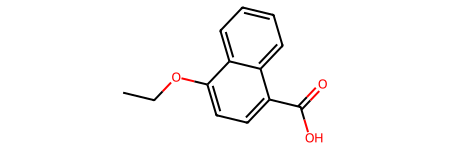

In [9]:
# Check how graph is build
print(y_train.iloc[0])
MolFromSmiles(X_train.iloc[0]["SMILES"])

In [10]:
# Investigating the graph
print("Dataset sample: ", train_dataset[0])
print("Sample nodes: ", train_dataset[0].num_nodes)
print("Sample edges: ", train_dataset[0].num_edges)
print()
print("Sample node features: ", train_dataset[0].x)
print()
print("Sample edge index: ", train_dataset[0].edge_index.t())
print()
print("Sample edge attributes: ", train_dataset[0].edge_attr)


Dataset sample:  Data(x=[16, 14], edge_index=[2, 34], edge_attr=[17, 3], y=-4.112199783325195)
Sample nodes:  16
Sample edges:  34

Sample node features:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 

# Build and train graph convolutional network

In [11]:
EMBEDDING_SIZE = 32

# Build network
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.input= GCNConv(14, EMBEDDING_SIZE)
        self.conv1 = GCNConv(EMBEDDING_SIZE, EMBEDDING_SIZE)
        self.conv2 = GCNConv(EMBEDDING_SIZE, EMBEDDING_SIZE)
        self.conv3 = GCNConv(EMBEDDING_SIZE, EMBEDDING_SIZE)
        
        # Dense layer
        self.dense = Linear(EMBEDDING_SIZE, 64)

        # Output layer
        self.output = Linear(64, 1)

    def forward(self, data):
        # Unpack data
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Input layer
        x = self.input(x, edge_index)
        x = F.relu(x)
        # Conv Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Conv Layer 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # Conv Layer 3
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        # Pooling layer
        x = global_max_pool(x, batch)
        # Dense layer
        x = self.dense(x)
        x = F.relu(x)
        # Output dense neuron
        output = self.output(x)

        return output

model = GCN()
print(model)

GCN(
  (input): GCNConv(14, 32)
  (conv1): GCNConv(32, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (dense): Linear(in_features=32, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)


In [12]:
# Setup loss and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Send to GPU
model = model.to(device)

# Setup training loop
def train(train_loader):
    # Set model to training mode
    model.train()
    for batch in train_loader:
      batch.to(device)
      optimizer.zero_grad()
      predictions = model(batch)
      
      # Calculating the loss and gradients
      loss = loss_fn(predictions.squeeze(), batch.y)
      loss.backward()
      
      # Update using the gradients
      optimizer.step()
      
    return loss
  
# Setup validation loop
def validate(val_loader):
  # set model to validation mode
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for batch in val_loader:
      batch.to(device)
      predictions = model(batch)
      
      # Calculating the loss
      loss = loss_fn(predictions.squeeze(), batch.y)
      val_loss += loss.item()
  
  # Return average loss over batch
  return val_loss / len(val_loader)  

# Perform training
print("Starting training")
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
patience = 50
patience_counter = 0

for epoch in range(5000):
    train_loss = train(train_loader)
    val_loss = validate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss {train_loss:.4f} | Validation Loss {val_loss:.4f}")

Starting training


/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss 5.3930 | Validation Loss 4.7990
Epoch 100 | Train Loss 0.8451 | Validation Loss 1.2997
Epoch 200 | Train Loss 0.7076 | Validation Loss 1.2389
Epoch 300 | Train Loss 0.8870 | Validation Loss 1.1066
Early stopping at epoch 359


In [13]:
print(best_val_loss)

1.0396600259201867


In [14]:
# Ensure the model is in evaluation mode
model.eval()

# List to store predictions
all_predictions = []

# No need to track gradients during evaluation
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        predictions = model(batch)
        all_predictions.append(predictions.cpu())

# Concatenate all predictions
all_predictions = torch.cat(all_predictions, dim=0)

# If your targets are single values
all_predictions = all_predictions.view(-1)

# Convert to numpy array if needed
all_predictions = all_predictions.numpy()

In [15]:
rmse_score = root_mean_squared_error(y_pred=all_predictions, y_true=y_val.values)
rmse_score

1.0347556139819518

# Build and train graph attention network

In [16]:
EMBEDDING_SIZE = 32
HEADS = 4

# Build network
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        torch.manual_seed(42)

        # GAT layers
        self.input = GATConv(14, EMBEDDING_SIZE // HEADS, heads=HEADS, concat=True)
        self.conv1 = GATConv(EMBEDDING_SIZE, EMBEDDING_SIZE // HEADS, heads=HEADS, concat=True)
        self.conv2 = GATConv(EMBEDDING_SIZE, EMBEDDING_SIZE // HEADS, heads=HEADS, concat=True)
        self.conv3 = GATConv(EMBEDDING_SIZE, EMBEDDING_SIZE // HEADS, heads=HEADS, concat=True)
        
        # Dense layer
        self.dense = Linear(EMBEDDING_SIZE, 64)

        # Output layer
        self.output = Linear(64, 1)

    def forward(self, data):
        # Unpack data
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Input layer
        x = self.input(x, edge_index)
        x = F.relu(x)
        # Conv Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Conv Layer 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # Conv Layer 3
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        # Pooling layer
        x = global_max_pool(x, batch)
        # Dense layer
        x = self.dense(x)
        x = F.relu(x)
        # Output dense neuron
        output = self.output(x)

        return output

model = GAT()
print(model)

GAT(
  (input): GATConv(14, 8, heads=4)
  (conv1): GATConv(32, 8, heads=4)
  (conv2): GATConv(32, 8, heads=4)
  (conv3): GATConv(32, 8, heads=4)
  (dense): Linear(in_features=32, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)


In [17]:
# Setup loss and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Send model to GPU
model = model.to(device)

# Setup training loop
def train(train_loader):
    # Set model to training mode
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        predictions = model(batch)
        
        # Calculating the loss and gradients
        loss = loss_fn(predictions.squeeze(), batch.y)
        loss.backward()
        
        # Update using the gradients
        optimizer.step()
        total_loss += loss.item()
      
    return total_loss / len(train_loader)

# Setup validation loop
def validate(val_loader):
    # Set model to validation mode
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            predictions = model(batch)
            
            # Calculating the loss
            loss = loss_fn(predictions.squeeze(), batch.y)
            val_loss += loss.item()
    
    # Return average loss over batch
    return val_loss / len(val_loader)

# Perform training
print("Starting training")
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
patience = 50
patience_counter = 0

for epoch in range(5000):
    train_loss = train(train_loader)
    val_loss = validate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss {train_loss:.4f} | Validation Loss {val_loss:.4f}")

Starting training


/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss 7.1978 | Validation Loss 4.7574


In [ ]:
print(best_val_loss)

1.055258491209575


In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# List to store predictions
all_predictions = []

# No need to track gradients during evaluation
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        predictions = model(batch)
        all_predictions.append(predictions.cpu())

# Concatenate all predictions
all_predictions = torch.cat(all_predictions, dim=0)

# If your targets are single values
all_predictions = all_predictions.view(-1)

# Convert to numpy array if needed
all_predictions = all_predictions.numpy()

rmse_score = root_mean_squared_error(y_pred=all_predictions, y_true=y_val.values)
rmse_score

1.1431621331793922